In [1]:
from qat.lang.AQASM import Program, QRoutine, H, CNOT, RX, RY, RZ, X, Z
from qat.qpus import get_default_qpu
from qat.core import Observable, Term
from qat.plugins import ObservableSplitter, ScipyMinimizePlugin

import numpy as np
import random
# pyqubo imports
from pyqubo import Binary, Spin, Array
from pprint import pprint
import matplotlib.pyplot as plt

/home/omp/anaconda3/envs/QML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hands-on: Problema da Mochila no VQE

## Descrição do problema

Imagine que voce tem uma mochila com capacidade $W$ (peso total) e barras de ouro de diversos pesos, $w_i$. Você quer colocar o máximo de ouro dentro da mochila, sem que sua capacidade seja ultrapassada. Quais barras de ouro colocar de forma a maximizar a quantidade de ouro dentro da mochila? Esta é uma versão simplificada do problema. Este exemplo pode ser generalizado para várias mochilas e objetos com valores e pesos diferentes.

<img src="imagens/mochila.jpeg" width=750 />

## Formulação como otimização irrestrita

Como queremos maximizar a quantidade de ouro dentro da mochila, podemos criar uma função objetivo de minimização da seguinte forma

$$H(\vec{x}) = \left(W - \sum_{i=0}^{n}w_ix_i\right)^2$$
onde $x_i=1$ se a barra de ouro $i$ está dentro da mochila e $x_i=0$ caso contrário. 





## Hands-on

Vamos fazer um exemplo simples, com poucas variáveis. Imagine que você possui 3 Barras: Barra 1 - `5kg`; Barra 2 - `3kg`; e Barra 3 - `1kg`. No entando, sua mochila tem a capacidade de apenas `6kg`. Qual é a melhor combinação de barras a se guardar na mochila de forma a minimizar a sobra? Use o VQE para solucionar o problema.

In [2]:
num_variables = 3
variables = Array.create('x', shape=num_variables, vartype='BINARY')
weights = [5,3,1]

### Exercício 1

Crie a função objetivo do problema usando o `Pyqubo`.

In [3]:
W = 6
H = (W - sum([wi*vi for wi, vi in zip(weights, variables)]))**2

H

((6.000000 + (-1.000000 * ((1.000000 * Binary('x[2]')) + (3.000000 * Binary('x[1]')) + 0.000000 + (5.000000 * Binary('x[0]'))))) * (6.000000 + (-1.000000 * ((1.000000 * Binary('x[2]')) + (3.000000 * Binary('x[1]')) + 0.000000 + (5.000000 * Binary('x[0]'))))))

### Converção para modelo de Ising

In [4]:
# -----------------------------------
# Transformando de Binary para Ising
# -----------------------------------

model = H.compile()
model = model.to_ising()
linear, quadratic = model[0], model[1]

print("Termos lineares do modelo de Ising", linear)
print("Termos quadráticos do modelo de Ising", quadratic)

Termos lineares do modelo de Ising {'x[2]': -1.5, 'x[1]': -4.5, 'x[0]': -7.5}
Termos quadráticos do modelo de Ising {('x[1]', 'x[2]'): 1.5, ('x[0]', 'x[2]'): 2.5, ('x[0]', 'x[1]'): 7.5}


### Exercício 2

Escreva o modelo de Ising em termos de operadores de Pauli-Z. Crie um dicionário para armazenar cada termo da seguinte forma:

Exemplo: `hamiltonian = {"ZIZ": 4, ...}` onde as chaves são strings com operadores de Pauli-Z e Identidade e os respectivos valores são seus coeficientes.

Para resolvermos o nosso problema usando o myQLM criaremos um observável usando o Hamiltoniano de Ising criado acima.

In [5]:
single_values = {}
multiple_values = {}
for k,v in linear.items():
    single_values[int(k[2])] = v
for k, v in quadratic.items():
    multiple_values[(int(k[0][2]), int(k[1][2]))] = v

num_qubits = len(variables)
hamiltonian = Observable(num_qubits
                           , pauli_terms=
                           [Term(single_values[x], "Z", [x]) for x in single_values]+
                           [Term(multiple_values[x], "ZZ", [x[0],x[1]]) for x in multiple_values]
                           )

print(hamiltonian)

-1.5 * (Z|[2]) +
-4.5 * (Z|[1]) +
-7.5 * (Z|[0]) +
1.5 * (ZZ|[1, 2]) +
2.5 * (ZZ|[0, 2]) +
7.5 * (ZZ|[0, 1])


### Ansatz

O ansatz é um circuito quântico parametrizado. Sua forma variacional pode ser dada por padrões heurísticos geralmente implementada através de operadores de rotação e portas CNOT para realizar emaranhamento entre os qubits. Uma forma variacional eficiente é aquela capaz de generalizar bem um estado quântico, aumentando o espaço de busca. Podemos escrever a atuação do circuito variacional, $U(\vec{\theta})$, sobre um sistema com $n$ qubits de estado inicial, $|0\rangle^{\otimes n}$, como

$$U(\vec{\theta})|0\rangle^{\otimes n} = |\psi(\vec{\theta})\rangle$$

Agora, realizaremos o mesmo processo do exemplo anterios, mas agora não estaremos interessados em ter um número como solução, e sim um vetor, o $\vec{z}$. Embora minimizaremos o valor esperado de um operador, estaremos interessados no autoestado com maior probabilidade, associado ao menor valor esperado.

### Exercício 3

Aplique as operações no ansatz e defina, no lugar do `FIXME`, o numero de parametros variacionais que voce usou.

In [6]:
def ansatz(num_qubits, var_params):

    routine = QRoutine()
    wires = routine.new_wires(num_qubits)

    # cria um ansatz com 3 layers e 12 parametros
    RX(var_params[0])(wires[0])
    RX(var_params[1])(wires[1])
    RX(var_params[2])(wires[2])

    RY(var_params[3])(wires[0])
    RY(var_params[4])(wires[1])
    RY(var_params[5])(wires[2])

    CNOT(wires[0],wires[1])
    CNOT(wires[0],wires[2])
    CNOT(wires[1],wires[2])
  
    return routine

num_params = 2*num_variables
circuit = ansatz(num_variables, [i for i in range(num_params)])
circuit.display()

In [7]:
qprog = Program()
qbits = qprog.qalloc(num_variables)

num_layers = 3
num_params = 2*num_variables
params  = [[qprog.new_var(float, '\\param%s'%i) for i in range(num_params)] for j in range(num_layers)]

for i in range(num_layers):
    qprog.apply(ansatz(num_variables, params[i]), qbits)


### Visualização do Circuito

In [8]:
circuit = qprog.to_circ()
print("total number of gates: ", len(circuit.ops))
print("Variables:", circuit.get_variables())
# Display quantum circuit
%qatdisplay circuit --svg

total number of gates:  27
Variables: ['\\param0', '\\param1', '\\param2', '\\param3', '\\param4', '\\param5']


## Valor esperado do operador hamiltoniano

O valor esperado pode ser dado pelo valor médio das energias. O valor esperado é a função a ser minimizada e pode ser dado por

$$\langle \psi_\theta | H | \psi_\theta \rangle = \sum_{i} E_ip_i$$

### Exercício 4


In [9]:
# Create a job
job = circuit.to_job(observable=hamiltonian)

result_list = []
# Escolha um número de iterações adequado
num_iterations = 10
for _ in range(num_iterations):
    # Inicialize p parâmetros gamma e p parâmetros beta iniciais entre os valores (0, 2*pi)
    initial_parameters = [random.uniform(0, 2*np.pi) for _ in range(num_layers*num_params)]
    cobyla = ScipyMinimizePlugin(tol=1e-6,
                                method="COBYLA",
                                options={"maxiter": 300},
                                x0=initial_parameters)
    # Create a Quantum Processor Unit
    qpu = get_default_qpu()

    stack =  cobyla | qpu

    # Submit the job to the QPU
    result_list.append(stack.submit(job))

#### Análise dos Resultados

In [10]:
for i, r in enumerate(result_list):
    print("Run", i, ", Final energy:", r.value)
    #Binding the variables:random.uniform(0, 2*np.pi)
    sol_job = job(**eval(r.meta_data["parameter_map"]))

    #Rerunning in 'SAMPLE' mode to get the most probable states:
    sampling_job = sol_job.circuit.to_job()

    sol_res = qpu.submit(sampling_job)
    print("Most probable states are:")
    for sample in sol_res:
        if sample.probability > 0.05:
            print(sample.state, "{:.2f}%".format(100 * sample.probability))

Run 0 , Final energy: -10.518971619455696
Most probable states are:
|010> 53.45%
|011> 46.14%
Run 1 , Final energy: -9.37036875963708
Most probable states are:
|001> 33.33%
|010> 59.26%
|100> 7.41%
Run 2 , Final energy: -10.519168534721445
Most probable states are:
|010> 53.47%
|011> 46.13%
Run 3 , Final energy: -9.370368378295527
Most probable states are:
|001> 33.34%
|010> 59.26%
|100> 7.40%
Run 4 , Final energy: -9.365348363485394
Most probable states are:
|001> 31.05%
|010> 60.27%
|100> 7.89%
Run 5 , Final energy: -10.60223055118864
Most probable states are:
|010> 64.87%
|011> 34.42%
Run 6 , Final energy: -9.333658977975729
Most probable states are:
|001> 28.29%
|010> 61.39%
|100> 8.24%
Run 7 , Final energy: -10.518468583423797
Most probable states are:
|010> 53.49%
|011> 46.08%
Run 8 , Final energy: -10.590570632903693
Most probable states are:
|010> 62.79%
|011> 36.67%
Run 9 , Final energy: -9.372115936243285
Most probable states are:
|001> 32.66%
|010> 59.62%
|100> 7.49%


In [11]:
# Escolhendo o resultado com o menor valor esperado
result = min(result_list, key=lambda s: s.value)
print("Final energy:", result.value)
for key, value in result.meta_data.items():
    print(key, ":", value)

Final energy: -10.60223055118864
optimizer_data :      fun: -10.60223055118864
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 300
  status: 2
 success: False
       x: array([ 7.79209443e-04,  6.77716432e-03,  1.43290908e+00,  1.30495069e-03,
        1.98237356e+00, -1.85217592e+00])
parameters : [0.0007792094433620054, 0.00677716431867225, 1.4329090802404407, 0.0013049506938370688, 1.9823735641063063, -1.85217591699598]
optimization_trace : [-4.399878326795411, -1.6862025208534166, -3.4633549763995357, -5.534292127129154, -5.087565539107797, -6.020813953822776, -4.767369198040103, -6.705121998391158, -6.4650037768955695, -5.266189444963013, -5.135183645164136, -5.7400903069258735, -7.0415559271231265, -6.683040357230723, -6.294283575163015, -7.2551866010653665, -6.962230421636242, -7.0025246774526275, -7.184958409969806, -7.377300294556406, -7.477942498978228, -7.242168676775119, -7.372974141190588, -7.745580500438498, -7.622618659875788,

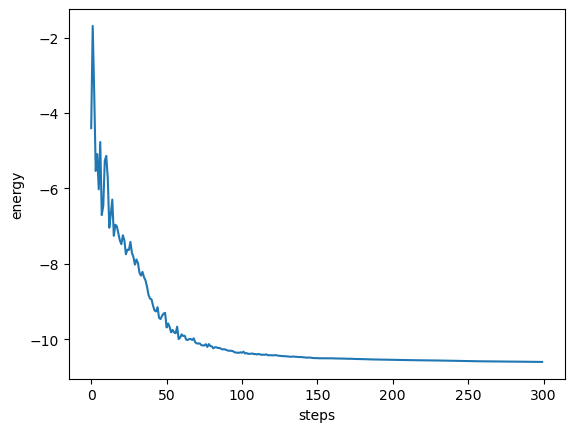

In [12]:
plt.plot(eval(result.meta_data["optimization_trace"]))
plt.xlabel("steps")
plt.ylabel("energy")
plt.show()

### Exercicio 5

Pegue os melhores parametros encontrados na minimização do valor esperado e aplique-os no ansatz. Este circuito será o circuito "ótimo" e medidas neste circuito nos dará informações sobre as melhores soluções.

In [13]:
# Emulating a reasonable setup:
# Drawing 2048 cuts
sol_job = job(**eval(result.meta_data["parameter_map"]))
sampling_job = sol_job.circuit.to_job(nbshots=2048)
sol_res = qpu.submit(sampling_job)

max_state = max([(s.state.value[0], s.probability) for s in sol_res], key=lambda s: s[1])
print("State with highest probability:"
      , max_state[0]
      , "%.2f%%" % (100 * max_state[1]) )



State with highest probability: 010 64.26%


O autoestado com maior ocorrência indica a solução ótima.